In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 20912 (delta 69), reused 15 (delta 5), pack-reused 20803
Receiving objects: 100% (20912/20912), 16.53 MiB | 7.66 MiB/s, done.
Resolving deltas: 100% (15289/15289), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728 

In [ ]:
%cd /content/LightGBM

/content/LightGBM


In [ ]:
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
import warnings
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss, make_scorer
from tqdm import tqdm
import lightgbm as lgb
import gc
import datetime
import time
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pickle.load(open('/content/drive/MyDrive/Casestudy1/train_features1.pkl','rb'))

In [ ]:
train.head()

,product_id,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered,cos_cyclic_hour,sin_cyclic_hour,cos_cyclic_day,sin_cyclic_day,daypriorratio,hod_ratio,product_hour_ratio,dow_ratio,product_day_ratio,user_product_ratio,user_day_ratio,user_hour_ratio,since_order_product,user_times_product,weight7days_sin_since_product,weight7days_cos_since_product,weight14days_sin_since_product,weight14days_cos_since_product,weight30days_sin_since_product,weight30days_cos_since_product,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29
0,33120,202279,1050357,9,1,14,30,1,-0.866211,-0.5,0.62349,0.781832,0.073653,0.081849,0.079526,0.178604,0.168146,0.090909,0.204545,0.272727,0.0,4.0,0.992464,0.393740,0.895916,0.816745,0.505000,1.005000,1.937152,-1.16688,0.238513,0.567141,0.109641,0.113536,-0.597428,-0.922533,-1.518292,-1.409214,-2.162558,-0.241033,-0.704218,1.03215,-1.88205,-0.776568,0.023648,-0.771358,-0.268655,0.220245,0.734494,-0.013646,-0.271632,-0.923037,-0.299156,-0.653588,0.476191,-0.811485,0.226917,-0.99085
1,33120,122042,1770556,11,1,14,30,0,-0.866211,-0.5,0.62349,0.781832,0.073653,0.081849,0.079526,0.178604,0.168146,0.059406,0.099010,0.000000,30.0,6.0,0.992464,0.393740,0.895916,0.816745,0.505000,1.005000,1.937152,-1.16688,0.238513,0.567141,0.109641,0.113536,-0.597428,-0.922533,-1.518292,-1.409214,-2.162558,-0.241033,-0.704218,1.03215,-1.88205,-0.776568,0.023648,-0.771358,-0.268655,0.220245,0.734494,-0.013646,-0.271632,-0.923037,-0.299156,-0.653588,0.476191,-0.811485,0.226917,-0.99085
2,33120,197605,2093514,26,1,14,30,1,-0.866211,-0.5,0.62349,0.781832,0.073653,0.081849,0.079526,0.178604,0.168146,0.070423,0.302817,0.021127,0.0,10.0,0.992464,0.393740,0.895916,0.816745,0.505000,1.005000,1.937152,-1.16688,0.238513,0.567141,0.109641,0.113536,-0.597428,-0.922533,-1.518292,-1.409214,-2.162558,-0.241033,-0.704218,1.03215,-1.88205,-0.776568,0.023648,-0.771358,-0.268655,0.220245,0.734494,-0.013646,-0.271632,-0.923037,-0.299156,-0.653588,0.476191,-0.811485,0.226917,-0.99085
3,33120,48533,1350816,11,1,14,30,0,-0.866211,-0.5,0.62349,0.781832,0.073653,0.081849,0.079526,0.178604,0.168146,0.018018,0.198198,0.009009,113.0,2.0,0.895916,0.816745,0.721942,0.955484,0.007739,0.557264,1.937152,-1.16688,0.238513,0.567141,0.109641,0.113536,-0.597428,-0.922533,-1.518292,-1.409214,-2.162558,-0.241033,-0.704218,1.03215,-1.88205,-0.776568,0.023648,-0.771358,-0.268655,0.220245,0.734494,-0.013646,-0.271632,-0.923037,-0.299156,-0.653588,0.476191,-0.811485,0.226917,-0.99085
4,33120,7443,2049554,8,1,14,30,0,-0.866211,-0.5,0.62349,0.781832,0.073653,0.081849,0.079526,0.178604,0.168146,0.074074,0.240741,0.000000,29.0,4.0,0.895916,0.816745,0.721942,0.955484,0.401044,0.994074,1.937152,-1.16688,0.238513,0.567141,0.109641,0.113536,-0.597428,-0.922533,-1.518292,-1.409214,-2.162558,-0.241033,-0.704218,1.03215,-1.88205,-0.776568,0.023648,-0.771358,-0.268655,0.220245,0.734494,-0.013646,-0.271632,-0.923037,-0.299156,-0.653588,0.476191,-0.811485,0.226917,-0.99085


In [ ]:
X = train.drop(['product_id','order_id'],axis=1)

In [ ]:
train.user_id.nunique()

131209

In [ ]:
total_users = list(train.user_id.unique())
total_users[:5]

[202279, 122042, 197605, 48533, 7443]

In [ ]:
random.shuffle(total_users)

In [ ]:
total_users[:5]

[27793, 147273, 186007, 37913, 149226]

In [ ]:
train_users = total_users[:101209]
test_users  = total_users[101209:]

In [ ]:
len(train_users),len(test_users),len(total_users)

(101209, 30000, 131209)

In [ ]:
X.set_index('user_id').loc[train_users,:]['reordered'].value_counts()

0    5987863
1     645109
Name: reordered, dtype: int64

In [ ]:
X_train = X.set_index('user_id').loc[train_users,:]
X_test  = X.set_index('user_id').loc[test_users,:]

In [ ]:
y_train = X_train.reordered
y_test  = X_test.reordered
X_train = X_train.drop(['reordered'],axis=1)
X_test = X_test.drop(['reordered'],axis=1)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6632972, 54), (1972898, 54), (6632972,), (1972898,))

In [ ]:
gc.collect()

0

In [ ]:
#https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/#:~:text=the%20model%20performance.-,What%20are%20the%20class%20weights%3F,the%20majority%20and%20minority%20classes.
lgbm=LGBMClassifier(device_type='gpu')

prams={
    'learning_rate':[0.05,0.1,0.15,0.2],
     'n_estimators':[50,100,150,200,300],
     'max_depth':[3,5,8,10],
     'num_leaves':[31,62,93],
     'class_weight':[{0:1,1:5},{0:1,1:10},{0:1,1:50}],
}
lgbm_cfl1=RandomizedSearchCV(lgbm,param_distributions=prams,verbose=10,scoring='f1',return_train_score=True,cv=3)
lgbm_cfl1.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START class_weight={0: 1, 1: 50}, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=93
[CV 1/3; 1/10] END class_weight={0: 1, 1: 50}, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=93; total time=  48.3s
[CV 2/3; 1/10] START class_weight={0: 1, 1: 50}, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=93
[CV 2/3; 1/10] END class_weight={0: 1, 1: 50}, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=93; total time=  48.2s
[CV 3/3; 1/10] START class_weight={0: 1, 1: 50}, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=93
[CV 3/3; 1/10] END class_weight={0: 1, 1: 50}, learning_rate=0.1, max_depth=5, n_estimators=200, num_leaves=93; total time=  47.9s
[CV 1/3; 2/10] START class_weight={0: 1, 1: 50}, learning_rate=0.05, max_depth=5, n_estimators=70, num_leaves=93
[CV 1/3; 2/10] END class_weight={0: 1, 1: 50}, learning_rate=0.05, max_depth=5, n_estimators=7

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(device_type='gpu'),
                   param_distributions={'class_weight': [{0: 1, 1: 5},
                                                         {0: 1, 1: 10},
                                                         {0: 1, 1: 50}],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [5, 8, 10],
                                        'n_estimators': [70, 100, 150, 200,
                                                         300],
                                        'num_leaves': [31, 62, 93]},
                   return_train_score=True, scoring='f1', verbose=10)

In [ ]:
pd.DataFrame(lgbm_cfl1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,38.308250,0.074506,9.801586,0.095338,93,200,5,0.1,"{0: 1, 1: 50}","{'num_leaves': 93, 'n_estimators': 200, 'max_d...",0.223525,0.224152,0.224841,0.224173,0.000537,9,0.224628,0.225040,0.224717,0.224795,0.000177
1,21.506200,0.059773,4.343197,0.008269,93,70,5,0.05,"{0: 1, 1: 50}","{'num_leaves': 93, 'n_estimators': 70, 'max_de...",0.215132,0.215883,0.216158,0.215724,0.000434,10,0.215768,0.216202,0.215509,0.215826,0.000286
2,50.557674,0.072111,13.802671,0.212984,62,300,10,0.1,"{0: 1, 1: 10}","{'num_leaves': 62, 'n_estimators': 300, 'max_d...",0.363141,0.362326,0.363483,0.362983,0.000486,1,0.368311,0.368580,0.368030,0.368307,0.000224
3,47.171308,0.244709,12.427966,0.119026,31,300,8,0.1,"{0: 1, 1: 50}","{'num_leaves': 31, 'n_estimators': 300, 'max_d...",0.225338,0.225924,0.226374,0.225879,0.000424,7,0.226995,0.227434,0.226769,0.227066,0.000276
4,20.567227,0.064628,4.488995,0.023273,31,70,5,0.2,"{0: 1, 1: 10}","{'num_leaves': 31, 'n_estimators': 70, 'max_de...",0.359050,0.357985,0.359273,0.358769,0.000562,4,0.360042,0.360106,0.360099,0.360082,0.000029
5,29.990971,0.053543,7.448748,0.169874,31,150,8,0.15,"{0: 1, 1: 50}","{'num_leaves': 31, 'n_estimators': 150, 'max_d...",0.224490,0.225273,0.225979,0.225247,0.000608,8,0.225768,0.226438,0.226106,0.226104,0.000274
6,26.610722,0.147394,6.177734,0.044868,93,100,10,0.2,"{0: 1, 1: 10}","{'num_leaves': 93, 'n_estimators': 100, 'max_d...",0.362628,0.361261,0.362901,0.362263,0.000718,2,0.368080,0.367596,0.367454,0.367710,0.000268
7,51.290805,0.169293,15.381318,0.017197,93,300,8,0.2,"{0: 1, 1: 50}","{'num_leaves': 93, 'n_estimators': 300, 'max_d...",0.235315,0.235924,0.236487,0.235909,0.000479,6,0.242825,0.243783,0.242677,0.243095,0.000490
8,25.335725,0.097043,5.647493,0.053756,31,100,5,0.1,"{0: 1, 1: 10}","{'num_leaves': 31, 'n_estimators': 100, 'max_d...",0.358092,0.356480,0.358946,0.357839,0.001022,5,0.358885,0.358324,0.359143,0.358784,0.000342
9,24.649941,0.171679,5.679319,0.071438,31,100,5,0.2,"{0: 1, 1: 10}","{'num_leaves': 31, 'n_estimators': 100, 'max_d...",0.359702,0.359146,0.360605,0.359817,0.000601,3,0.361541,0.361608,0.361893,0.361681,0.000153


In [ ]:
#best1
lgbm_cfl1.best_params_

{'class_weight': {0: 1, 1: 10},
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 300,
 'num_leaves': 62}

In [ ]:
lgbm=LGBMClassifier(device_type='gpu',class_weight={0:1,1:5},learning_rate=0.1,max_depth=10,n_estimators=1200,num_leaves=63,random_state=0)
lgbm.fit(X_train,y_train)

LGBMClassifier(class_weight={0: 1, 1: 5}, device_type='gpu', max_depth=10,
               n_estimators=1200, num_leaves=63, random_state=0)

In [ ]:
f1_score(y_test,lgbm.predict(X_test),average=None),f1_score(y_test,lgbm.predict(X_test))

(array([0.9130187 , 0.42731386]), 0.4273138591291579)

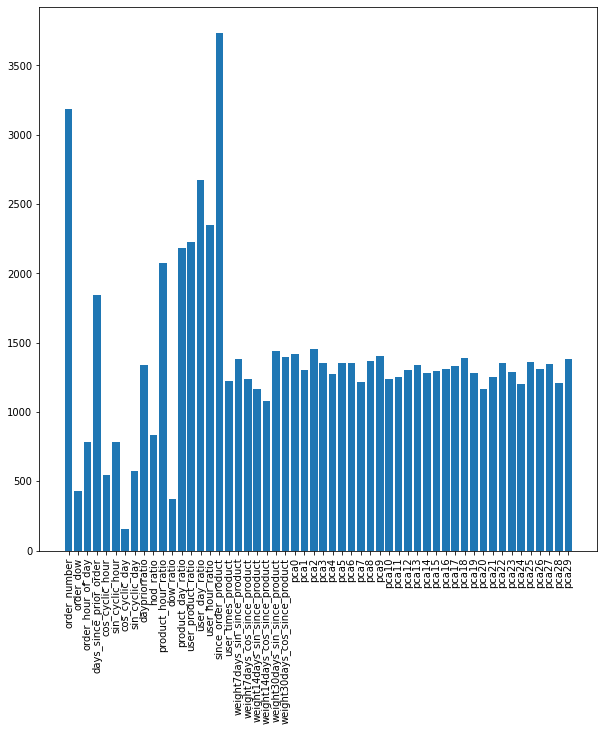

In [ ]:
plt.figure(figsize=(10,10))
plt.bar(X_train.columns,lgbm.feature_importances_)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
pickle.dump(lgbm,open('/content/lgbm_0.38596private.sav','wb'))

In [ ]:
X_train.columns

Index(['order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'cos_cyclic_hour', 'sin_cyclic_hour',
       'cos_cyclic_day', 'sin_cyclic_day', 'daypriorratio', 'hod_ratio',
       'product_hour_ratio', 'dow_ratio', 'product_day_ratio',
       'user_product_ratio', 'user_day_ratio', 'user_hour_ratio',
       'since_order_product', 'user_times_product', 'pca0', 'pca1', 'pca2',
       'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10',
       'pca11', 'pca12', 'pca13', 'pca14', 'pca15', 'pca16', 'pca17', 'pca18',
       'pca19', 'pca20', 'pca21', 'pca22', 'pca23', 'pca24', 'pca25', 'pca26',
       'pca27', 'pca28', 'pca29'],
      dtype='object')

In [ ]:
Test = pickle.load(open('/content/drive/MyDrive/Casestudy1/test_data_2.pkl','rb'))

In [ ]:
test = Test[X_train.columns]

In [ ]:
loaded_model = pickle.load(open('/content/lgbm_0.38596private.sav','rb'))

In [ ]:
result = loaded_model.predict(test)

In [ ]:
def sub(result):
  sub = pd.DataFrame()
  sub['order_id'] = Test.order_id
  sub['products'] = Test.product_id
  sub['reordered'] = result
  temp = sub.groupby('order_id').agg({'reordered':'sum'}).reset_index()
  temp = temp[temp.reordered==0]
  print(len(temp))
  if len(temp)!=0:
    temp['reordered'] = ['None' for i in range(0,len(temp))]
    temp.columns = ['order_id','products']
    sub = sub[sub.reordered==1]
    sub.drop(['reordered'],axis=1,inplace=True)
    sub = sub.sort_values(by ='order_id')
    sub.products = sub.products.astype('str')
    sub = sub.groupby('order_id')['products'].apply(' '.join).reset_index()
    pd.concat([sub,temp],ignore_index=True).to_csv('/content/submission.csv',index=False)
  else:
    sub = sub[sub.reordered==1]
    sub.drop(['reordered'],axis=1,inplace=True)
    sub = sub.sort_values(by ='order_id')
    sub.products = sub.products.astype('str')
    sub = sub.groupby('order_id')['products'].apply(' '.join).reset_index()
    sub.to_csv('/content/submission.csv',index=False)

sub(result)
  


284
